In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 24844 files belonging to 10 classes.


In [4]:
# Get the number of classes
class_names = dataset.class_names
n_classes = len(class_names)  

print("Class Names:", class_names)
print("Number of Classes:", n_classes)

Class Names: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy']
Number of Classes: 10


In [5]:
len(dataset)

777

In [6]:
for image_batch, label_batch in dataset.take(1):
    print("Image batch shape:", image_batch.shape)  # Shape of one batch
    print("Label batch:", label_batch.numpy())     # Labels corresponding to the batch

Image batch shape: (32, 256, 256, 3)
Label batch: [6 8 2 9 0 3 9 5 8 5 5 9 4 3 2 5 3 6 4 2 9 1 1 3 4 7 3 0 9 3 3 7]


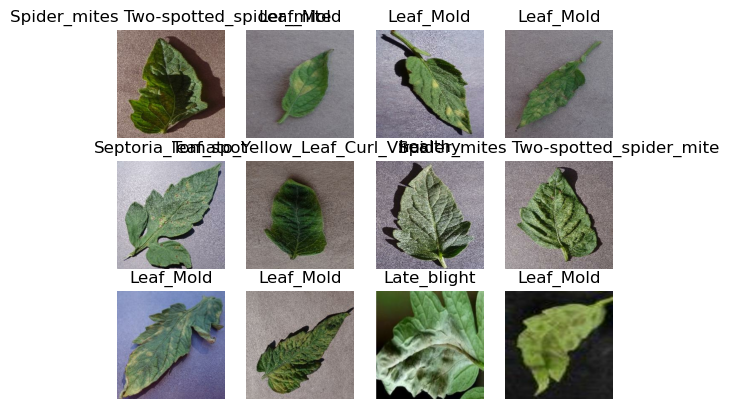

In [7]:
 for image_batch, label_batch in dataset.take(1):  # Take one batch of images
    # Loop through the first 12 images in the batch to display
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # Create a subplot in a 3x4 grid
        # Convert the tensor to uint8 (suitable for display) and show the image
        plt.imshow(image_batch[i].numpy().astype('uint8'))  # Convert tensor to uint8 for display
        # Use the label index to get the class name from `class_names`
        plt.title(class_names[int(label_batch[i])])  # Correct: directly index label_batch[i] without .numpy()
        plt.axis("off")  # Hide axis for better visualization

# Optionally, show the plot
plt.show()

In [8]:
#*80% ==>training,
#0% ==>10% validation, 10% test

In [9]:
train_size=0.8
len(dataset)*train_size

621.6

In [10]:
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

723

In [12]:
val_size=0.1
len(dataset)*val_size

77.7

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

717

In [15]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

print("Training samples:", len(train_ds))
print("Validation samples:", len(val_ds))
print("Test samples:", len(test_ds))

Training samples: 621
Validation samples: 77
Test samples: 79


In [16]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [17]:
len(train_ds)

621

In [18]:
len(val_ds)

77

In [19]:
len(test_ds)

79

In [20]:
# Optimize dataset loading
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])


In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [35]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

resize_and_rescale = tf.keras.Sequential([
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
])

model = models.Sequential([
    layers.Input(shape=input_shape),  # First layer specifying input shape
    resize_and_rescale,
    data_augmentation,

    # 1st Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),  # No input_shape here
    layers.MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), 
])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,394 (13.73 MB)

 Trainable params: 3,600,394 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,600,394 (13.73 MB)

 Trainable params: 3,600,394 (13.73 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Set from_logits=False since softmax is applied
    metrics=['accuracy']
)

In [41]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node decode_image/DecodeImage defined at (most recent call last):
<stack traces unavailable>
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_2974]

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize =(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}.\n confidence: {confidence}%")


        plt.axis("off")